In [4]:
pip install numpy-financial

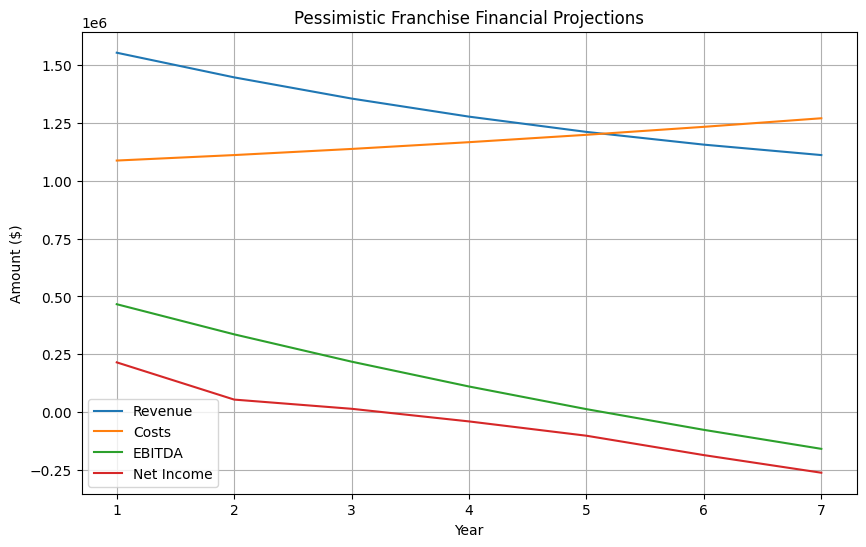

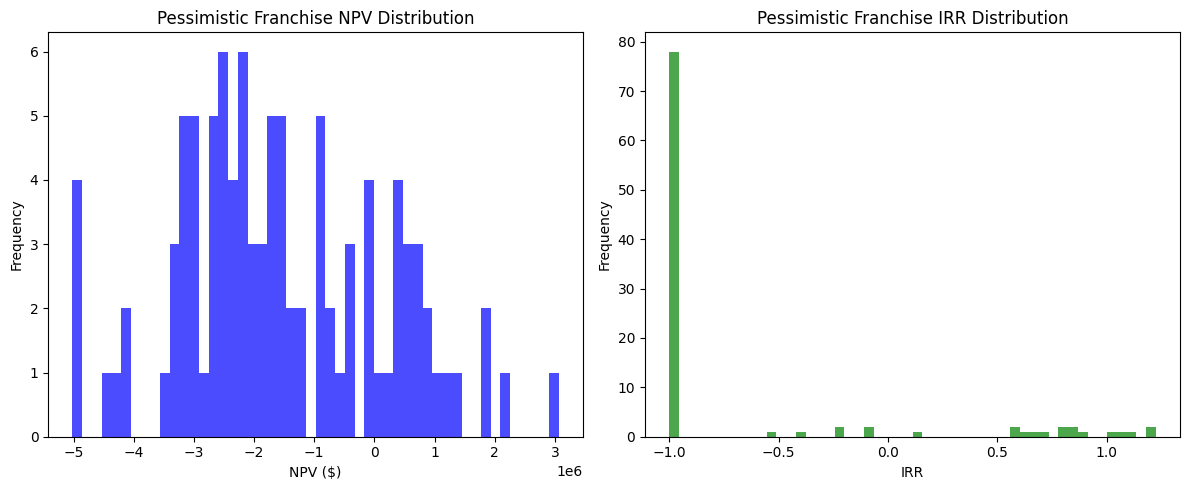

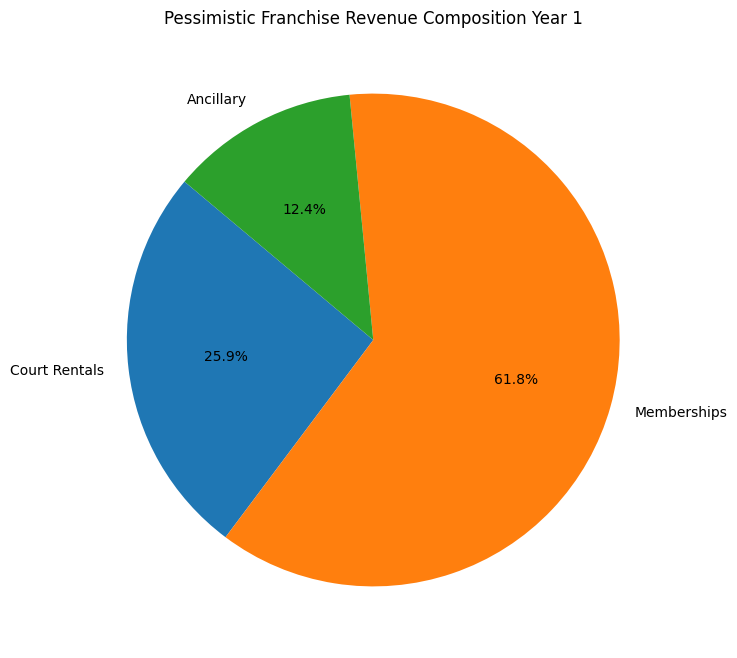

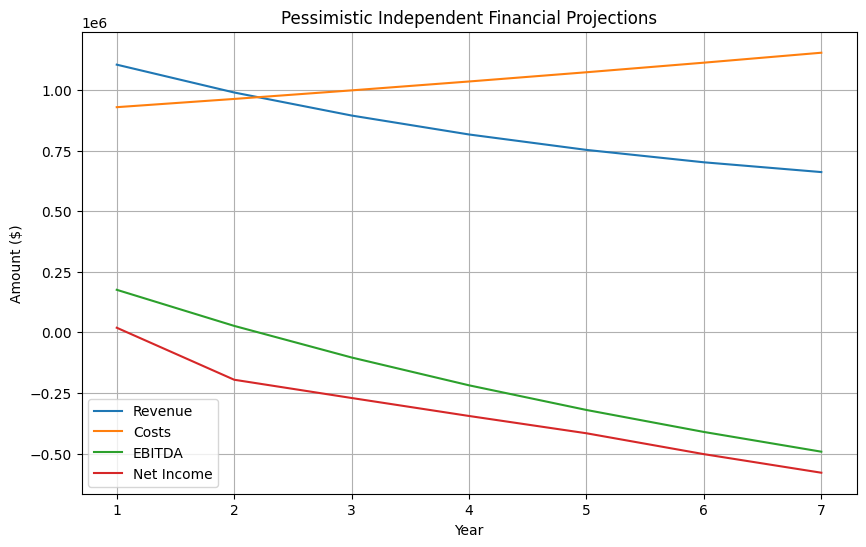

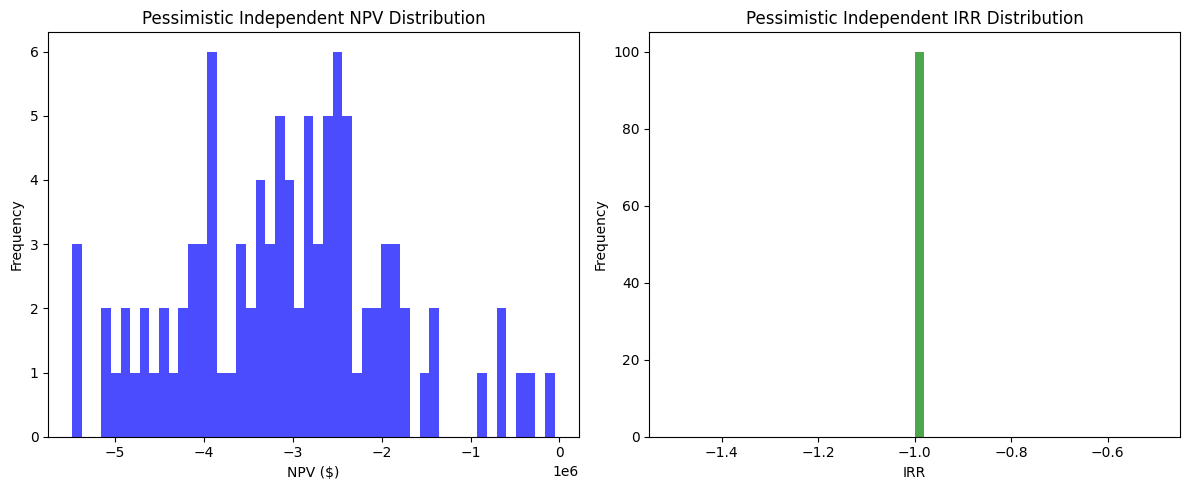

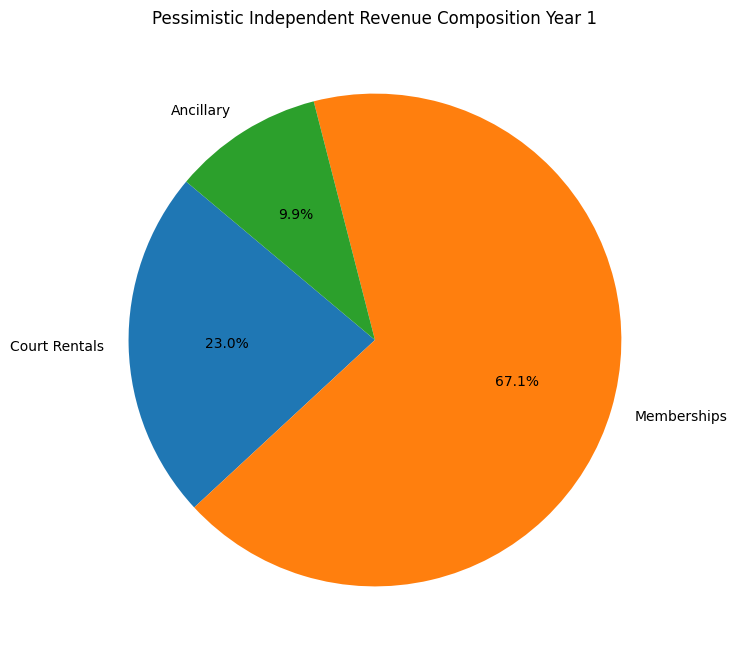

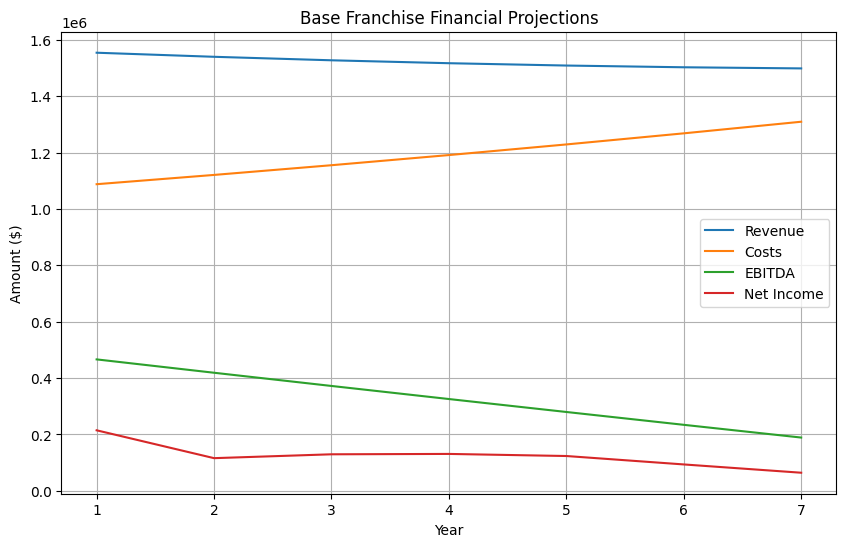

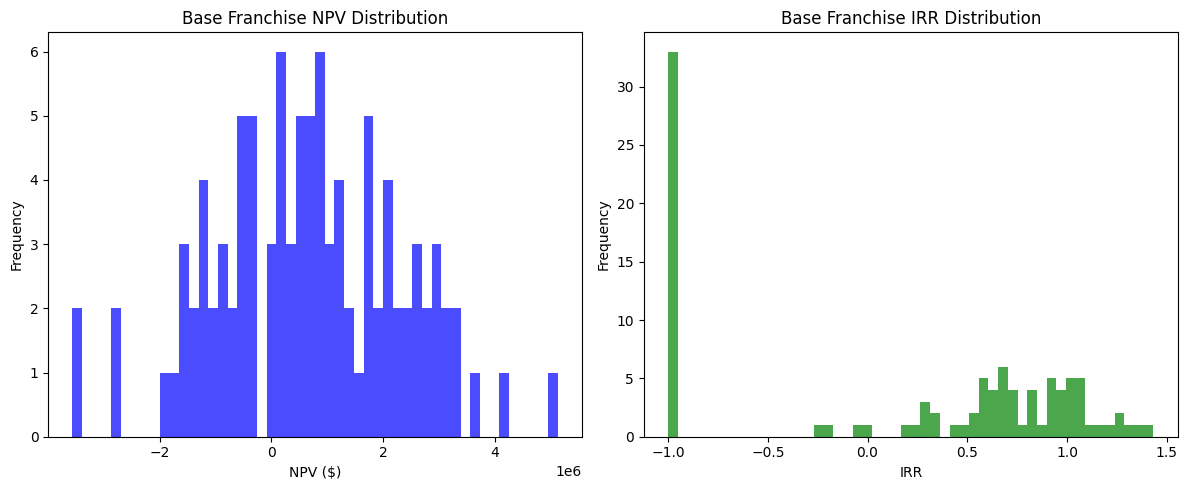

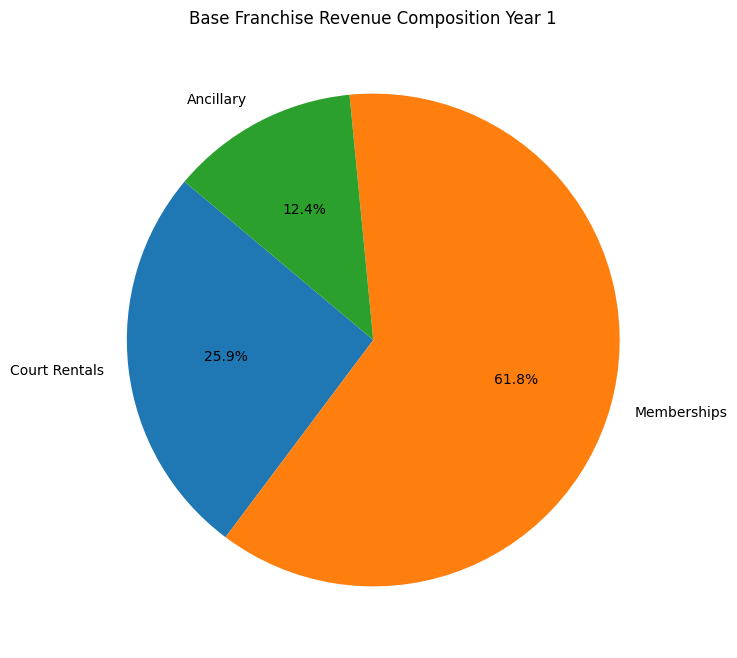

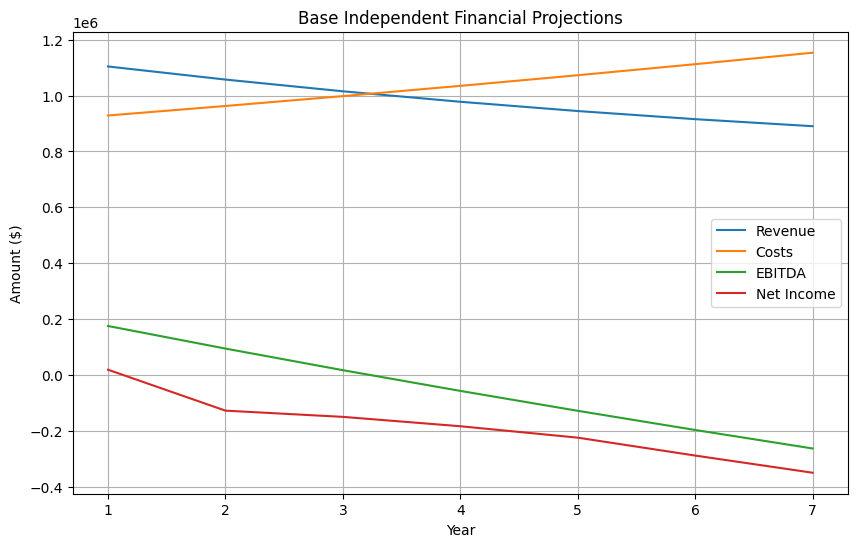

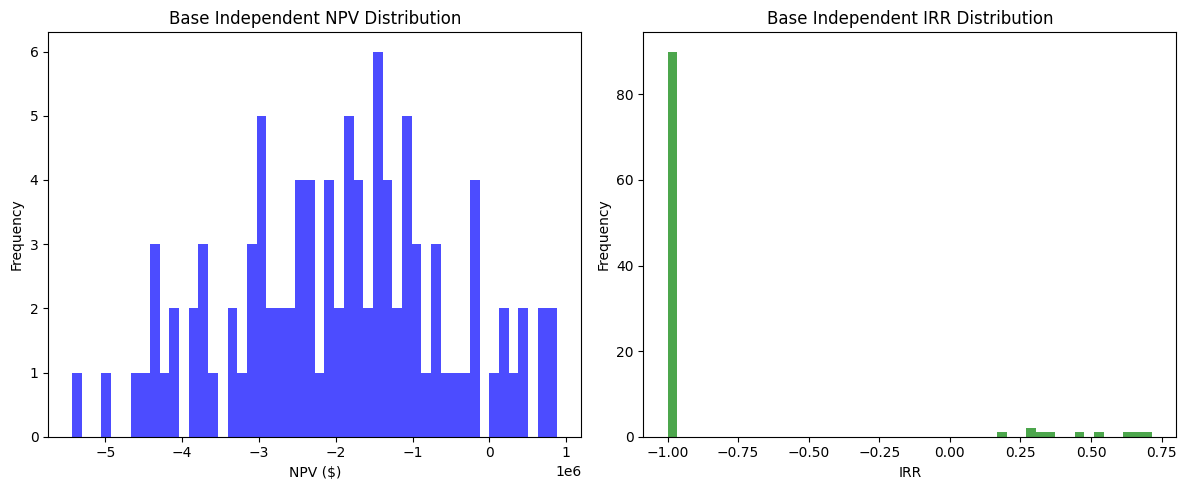

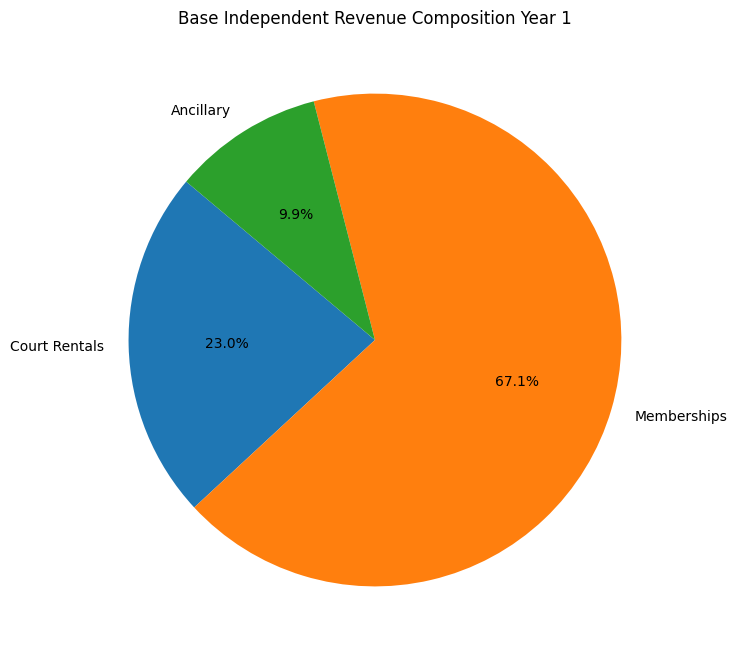

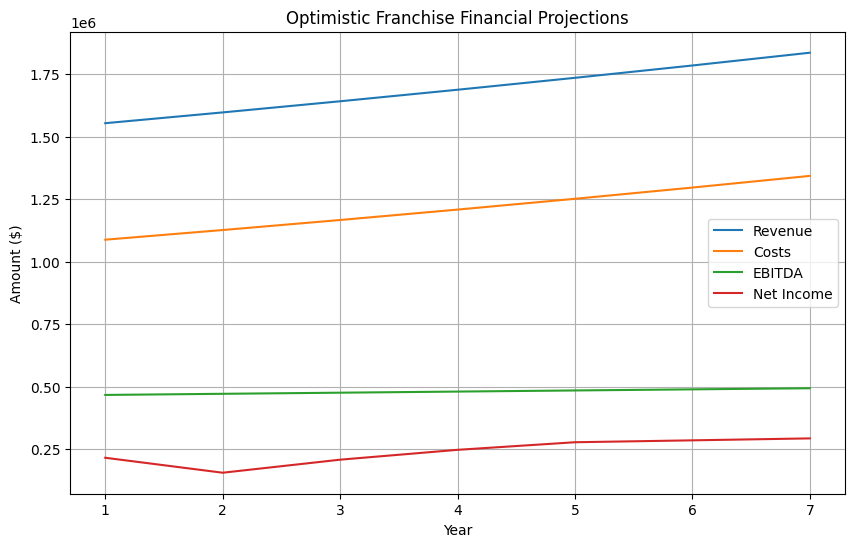

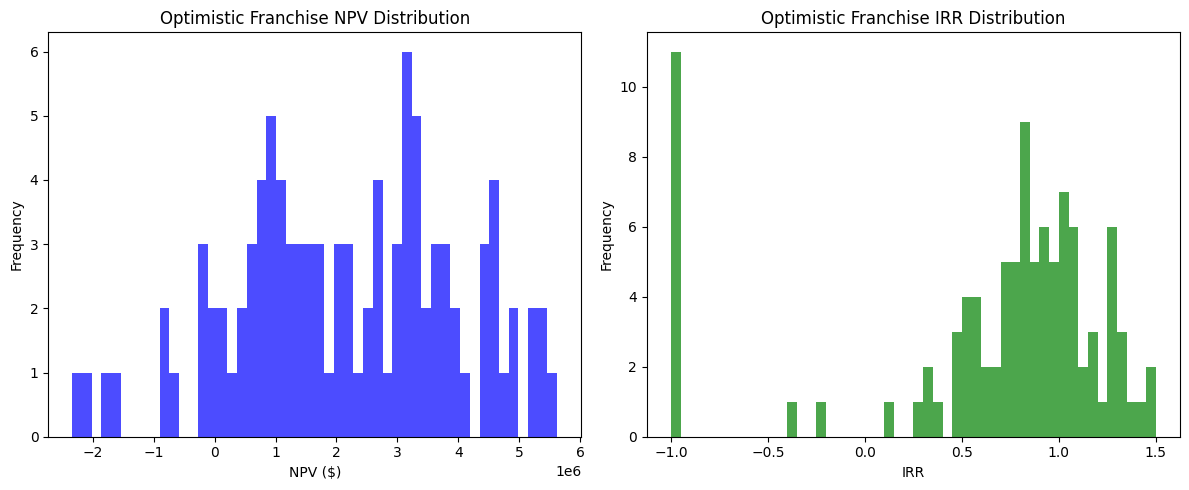

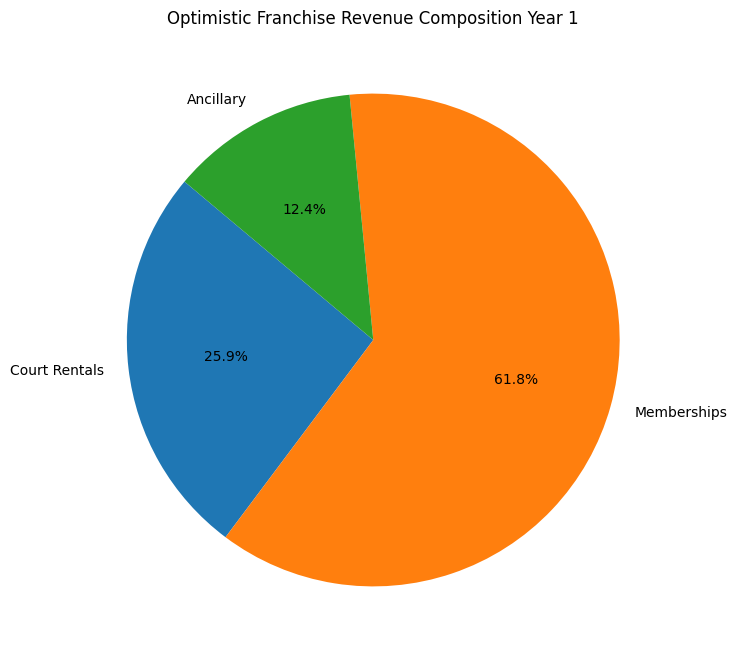

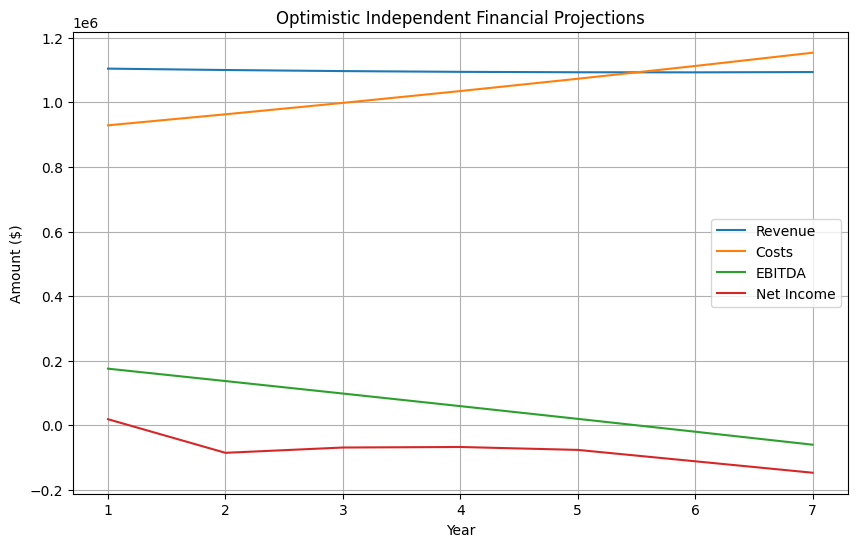

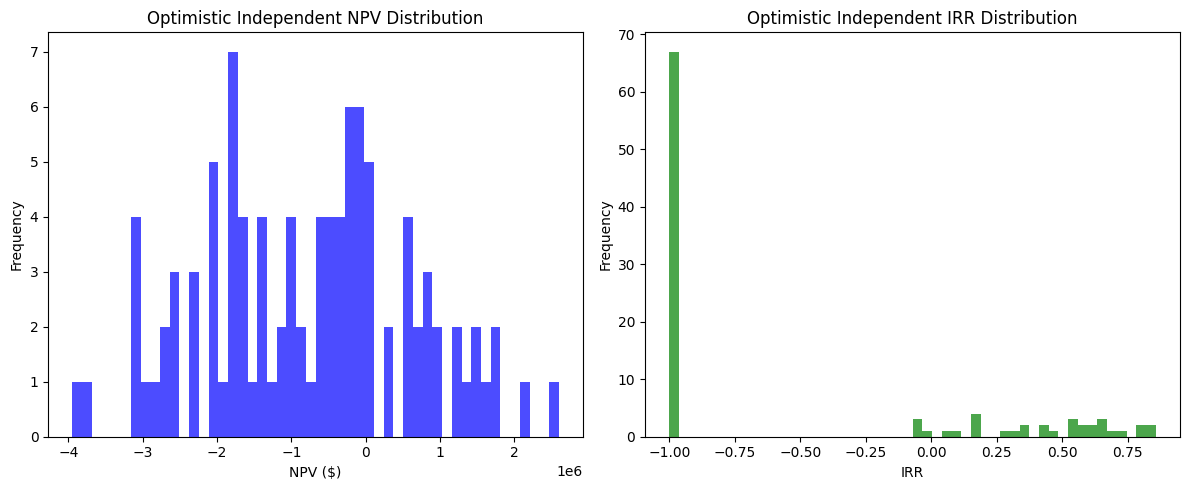

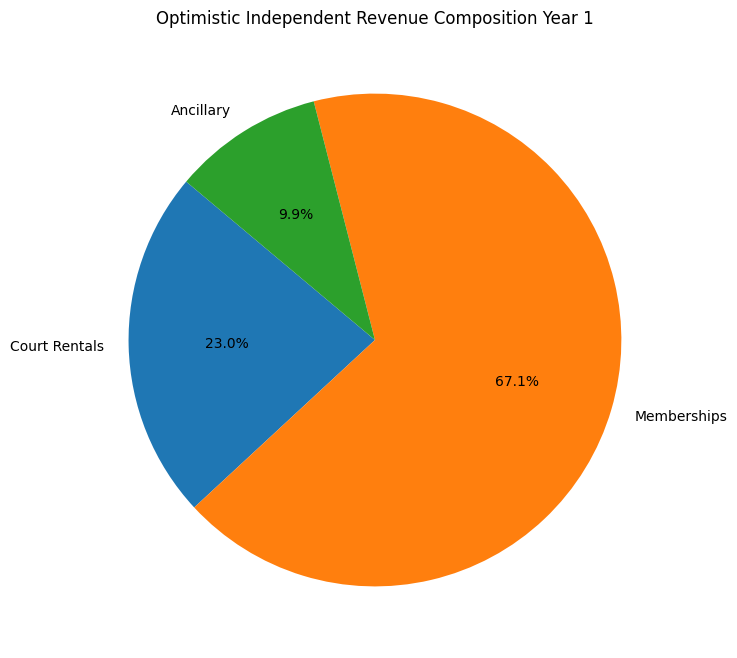

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy_financial as npf
from typing import Dict, List
import logging
import sys

# Set up logging to display on console
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Check if running in Jupyter
def in_jupyter():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' in get_ipython().config:
            return True
    except:
        return False
    return False

IS_JUPYTER = in_jupyter()

# Constants
MACRS_7_YEAR = [0.1429, 0.2449, 0.1749, 0.1249, 0.0893, 0.0892, 0.0893]
CHURN_RATE_STD = 0.05
UTILIZATION_STD = 0.10

# Base configuration for franchise model
base_franchise_config = {
    'initial_investment': 867000,
    'working_capital_percent_revenue': 0.08,
    'contingency_reserve': 100000,
    'financing_ratio': 0.7,
    'interest_rate': 0.08,
    'loan_term_years': 10,
    'num_courts': 12,
    'court_hours_per_day': 14,
    'days_open_per_year': 360,
    'facility_square_feet': 24000,
    'capacity_members': 1200,
    'monthly_membership_fee': 100,
    'num_members_year1': 800,
    'court_utilization_year1': 0.35,
    'prime_time_rate': 25,
    'off_peak_rate': 15,
    'prime_time_percentage': 0.4,
    'ancillary_rev_per_member_monthly': 20,
    'rent_per_sqft_monthly': 1.25,
    'utilities_base': 3500,
    'utilities_per_sqft': 0.15,
    'insurance_monthly': 2800,
    'staff_management': 12000,
    'staff_front_desk': 8000,
    'staff_maintenance': 4000,
    'staff_instructors_base': 3000,
    'staff_instructors_variable': 3000,
    'marketing_base': 5000,
    'equipment_maintenance_monthly': 1500,
    'supplies_monthly': 800,
    'professional_services': 1200,
    'equipment_replacement_annual': 15000,
    'operating_cost_inflation': 0.04,
    'rent_escalation': 0.03,
    'franchise_fee': 65000,
    'royalty_rate': 0.08,
    'marketing_fee_rate': 0.02,
    'years': 7,
    'tax_rate': 0.25,
    'terminal_growth_rate': 0.02,
    'discount_rate': 0.12,
    'member_acquisition_rate': 0.15,
    'member_churn_rate': 0.18,
    'max_utilization': 0.75
}

# Base configuration for independent model
base_independent_config = base_franchise_config.copy()
base_independent_config.update({
    'initial_investment': 736950,
    'financing_ratio': 0.65,
    'interest_rate': 0.085,
    'capacity_members': 1100,
    'num_members_year1': 650,
    'court_utilization_year1': 0.25,
    'monthly_membership_fee': 95,
    'prime_time_rate': 22,
    'off_peak_rate': 14,
    'prime_time_percentage': 0.35,
    'ancillary_rev_per_member_monthly': 14,
    'discount_rate': 0.14,
    'royalty_rate': 0.0,
    'marketing_fee_rate': 0.0,
    'member_churn_rate': 0.22
})

# Scenario adjustments
scenario_adjustments = {
    'pessimistic': {
        'member_churn_rate_adj': 0.08,
        'court_utilization_mature_adj': -0.15,
        'market_maturation_factor': 0.88
    },
    'base': {
        'member_churn_rate_adj': 0.0,
        'court_utilization_mature_adj': 0.0,
        'market_maturation_factor': 0.98
    },
    'optimistic': {
        'member_churn_rate_adj': -0.05,
        'court_utilization_mature_adj': 0.10,
        'market_maturation_factor': 1.02
    }
}

def get_scenario_config(scenario: str, model_type: str) -> Dict:
    """Retrieve and adjust configuration based on scenario and model type."""
    if model_type == 'franchise':
        config = base_franchise_config.copy()
    else:
        config = base_independent_config.copy()

    adj = scenario_adjustments[scenario]
    config['member_churn_rate'] += adj['member_churn_rate_adj']
    return config

def calculate_revenue(cfg: Dict, members: int, utilization: float, year: int) -> float:
    """Calculate annual revenue from court rentals, memberships, and ancillary services."""
    total_court_hours = cfg['num_courts'] * cfg['court_hours_per_day'] * cfg['days_open_per_year']
    court_rental_revenue = total_court_hours * utilization * (
        cfg['prime_time_percentage'] * cfg['prime_time_rate'] +
        (1 - cfg['prime_time_percentage']) * cfg['off_peak_rate']
    )
    membership_revenue = members * cfg['monthly_membership_fee'] * 12
    ancillary_revenue = members * cfg['ancillary_rev_per_member_monthly'] * 12
    return court_rental_revenue + membership_revenue + ancillary_revenue

def calculate_costs(cfg: Dict, members: int, utilization: float, year: int) -> float:
    """Calculate annual operating costs including rent, utilities, staff, and franchise fees."""
    cost_inflation = (1 + cfg['operating_cost_inflation']) ** year
    rent = cfg['rent_per_sqft_monthly'] * cfg['facility_square_feet'] * 12 * (1 + cfg['rent_escalation']) ** year
    utilities = (cfg['utilities_base'] + cfg['facility_square_feet'] * cfg['utilities_per_sqft']) * 12 * cost_inflation
    staff_costs = (cfg['staff_management'] + cfg['staff_front_desk'] + cfg['staff_maintenance'] +
                   cfg['staff_instructors_base'] + cfg['staff_instructors_variable'] * utilization) * 12 * cost_inflation
    other_costs = (cfg['insurance_monthly'] + cfg['marketing_base'] + cfg['equipment_maintenance_monthly'] +
                   cfg['supplies_monthly'] + cfg['professional_services']) * 12 * cost_inflation
    equipment_replacement = cfg['equipment_replacement_annual'] * cost_inflation
    franchise_costs = (cfg['royalty_rate'] * calculate_revenue(cfg, members, utilization, year) +
                      cfg['marketing_fee_rate'] * calculate_revenue(cfg, members, utilization, year)) if cfg['royalty_rate'] > 0 else 0
    return rent + utilities + staff_costs + other_costs + equipment_replacement + franchise_costs

def calculate_debt_schedule(principal: float, annual_rate: float, loan_term_years: int) -> List[Dict]:
    """Calculate the debt repayment schedule over the loan term."""
    monthly_rate = annual_rate / 12
    num_payments = loan_term_years * 12
    monthly_payment = principal * (monthly_rate * (1 + monthly_rate) ** num_payments) / ((1 + monthly_rate) ** num_payments - 1) if monthly_rate > 0 else principal / num_payments
    schedule = []
    balance = principal
    for year in range(loan_term_years):
        annual_interest = 0
        annual_principal = 0
        for _ in range(12):
            if balance <= 0:
                break
            interest = balance * monthly_rate
            principal_pmt = min(monthly_payment - interest, balance)
            balance -= principal_pmt
            annual_interest += interest
            annual_principal += principal_pmt
        schedule.append({
            'annual_interest': annual_interest,
            'annual_principal': annual_principal,
            'remaining_balance': max(0, balance)
        })
    return schedule

def calculate_financials(cfg: Dict, is_franchise: bool) -> Dict:
    """Calculate financial projections including NPV and IRR."""
    years = cfg['years']
    total_initial_investment = cfg['initial_investment'] + cfg['contingency_reserve'] + (cfg['franchise_fee'] if is_franchise else 0)
    debt_amount = total_initial_investment * cfg['financing_ratio']
    equity_amount = total_initial_investment - debt_amount
    debt_schedule = calculate_debt_schedule(debt_amount, cfg['interest_rate'], cfg['loan_term_years'])

    results = {
        'year': [], 'revenues': [], 'operating_costs': [], 'ebitda': [], 'net_income': [],
        'free_cash_flows': [], 'members': [], 'utilization': []
    }

    members = cfg['num_members_year1']
    utilization = cfg['court_utilization_year1']
    last_revenue = 0

    for year in range(years):
        revenue = calculate_revenue(cfg, members, utilization, year)
        costs = calculate_costs(cfg, members, utilization, year)
        ebitda = revenue - costs
        depreciation = cfg['initial_investment'] * MACRS_7_YEAR[year] if year < len(MACRS_7_YEAR) else 0
        interest = debt_schedule[year]['annual_interest'] if year < len(debt_schedule) else 0
        principal_payment = debt_schedule[year]['annual_principal'] if year < len(debt_schedule) else 0
        ebt = ebitda - depreciation - interest
        taxes = max(0, ebt * cfg['tax_rate'])
        net_income = ebt - taxes
        target_wc = revenue * cfg['working_capital_percent_revenue']
        wc_change = target_wc - (last_revenue * cfg['working_capital_percent_revenue'] if year > 0 else 0)
        last_revenue = revenue
        capex = cfg['equipment_replacement_annual'] * (1 + cfg['operating_cost_inflation']) ** year
        free_cash_flow = net_income + depreciation - capex - wc_change - principal_payment

        results['year'].append(year + 1)
        results['revenues'].append(revenue)
        results['operating_costs'].append(costs)
        results['ebitda'].append(ebitda)
        results['net_income'].append(net_income)
        results['free_cash_flows'].append(free_cash_flow)
        results['members'].append(members)
        results['utilization'].append(utilization)

        members = min(cfg['capacity_members'], members * (1 + cfg['member_acquisition_rate'] - cfg['member_churn_rate']))
        utilization = min(cfg['max_utilization'], utilization * (1 + 0.05))

    cash_flows = [-equity_amount] + results['free_cash_flows']
    terminal_value = cash_flows[-1] * (1 + cfg['terminal_growth_rate']) / (cfg['discount_rate'] - cfg['terminal_growth_rate'])
    cash_flows[-1] += terminal_value
    npv = npf.npv(cfg['discount_rate'], cash_flows)
    irr = npf.irr(cash_flows) if cash_flows[0] < 0 else np.nan

    return {
        'cash_flows': cash_flows,
        'npv': npv,
        'irr': irr,
        'detailed_results': results
    }

def run_monte_carlo_scenario(cfg: Dict, is_franchise: bool, num_simulations: int = 5000) -> Dict:
    """Run Monte Carlo simulations to assess financial variability."""
    npvs, irrs = [], []
    for _ in range(num_simulations):
        cfg_copy = cfg.copy()
        cfg_copy['num_members_year1'] = max(0, np.random.normal(cfg['num_members_year1'], cfg['num_members_year1'] * 0.1))
        cfg_copy['court_utilization_year1'] = max(0, min(1, np.random.normal(cfg['court_utilization_year1'], UTILIZATION_STD)))
        cfg_copy['member_churn_rate'] = max(0, np.random.normal(cfg['member_churn_rate'], CHURN_RATE_STD))
        results = calculate_financials(cfg_copy, is_franchise)
        npvs.append(results['npv'])
        irrs.append(results['irr'] if not np.isnan(results['irr']) else -1)
    return {'npv_dist': npvs, 'irr_dist': irrs}

def plot_financial_projections(results: Dict, scenario: str, model_type: str):
    """Plot financial projections over the years and display on screen."""
    df = pd.DataFrame(results['detailed_results'])
    plt.figure(figsize=(10, 6))
    plt.plot(df['year'], df['revenues'], label='Revenue')
    plt.plot(df['year'], df['operating_costs'], label='Costs')
    plt.plot(df['year'], df['ebitda'], label='EBITDA')
    plt.plot(df['year'], df['net_income'], label='Net Income')
    plt.title(f'{scenario.capitalize()} {model_type.capitalize()} Financial Projections')
    plt.xlabel('Year')
    plt.ylabel('Amount ($)')
    plt.legend()
    plt.grid(True)
    if not IS_JUPYTER:
        plt.show()
    else:
        plt.show(block=False)

def plot_monte_carlo_results(mc_results: Dict, scenario: str, model_type: str):
    """Plot NPV and IRR distributions from Monte Carlo simulations and display on screen."""
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(mc_results['npv_dist'], bins=50, color='blue', alpha=0.7)
    plt.title(f'{scenario.capitalize()} {model_type.capitalize()} NPV Distribution')
    plt.xlabel('NPV ($)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(mc_results['irr_dist'], bins=50, color='green', alpha=0.7)
    plt.title(f'{scenario.capitalize()} {model_type.capitalize()} IRR Distribution')
    plt.xlabel('IRR')
    plt.ylabel('Frequency')
    plt.tight_layout()
    if not IS_JUPYTER:
        plt.show()
    else:
        plt.show(block=False)

def plot_revenue_composition(cfg: Dict, results: Dict, year_idx: int, scenario: str, model_type: str):
    """Plot revenue composition for a specific year and display on screen."""
    revenue = calculate_revenue(cfg, results['members'][year_idx], results['utilization'][year_idx], year_idx)
    court_revenue = (cfg['num_courts'] * cfg['court_hours_per_day'] * cfg['days_open_per_year'] * results['utilization'][year_idx] *
                     (cfg['prime_time_percentage'] * cfg['prime_time_rate'] + (1 - cfg['prime_time_percentage']) * cfg['off_peak_rate']))
    membership_revenue = results['members'][year_idx] * cfg['monthly_membership_fee'] * 12
    ancillary_revenue = results['members'][year_idx] * cfg['ancillary_rev_per_member_monthly'] * 12
    labels = ['Court Rentals', 'Memberships', 'Ancillary']
    sizes = [court_revenue, membership_revenue, ancillary_revenue]
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'{scenario.capitalize()} {model_type.capitalize()} Revenue Composition Year {year_idx + 1}')
    if not IS_JUPYTER:
        plt.show()
    else:
        plt.show(block=False)

if __name__ == "__main__":
    for scenario in ['pessimistic', 'base', 'optimistic']:
        for model_type in ['franchise', 'independent']:
            cfg = get_scenario_config(scenario, model_type)
            logging.info(f"Processing {scenario} {model_type} scenario...")
            financial_results = calculate_financials(cfg, model_type == 'franchise')
            mc_results = run_monte_carlo_scenario(cfg, model_type == 'franchise', num_simulations=100)  # Reduced for speed
            plot_financial_projections(financial_results, scenario, model_type)
            plot_monte_carlo_results(mc_results, scenario, model_type)
            plot_revenue_composition(cfg, financial_results['detailed_results'], 0, scenario, model_type)
            logging.info(f"NPV: ${financial_results['npv']:,.2f}, IRR: {financial_results['irr']:.2%}")

    if not IS_JUPYTER:
        input("Press Enter to continue...")